In [1]:
# your code here

#Name: Harshil

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from astropy import constants as const
from astropy import units as u
plt.rcParams.update({'font.size': 16})

## Circumbinary Orbits

### Unit choice
The choice of units I picked was astro units: distances in AU, time in years, and masses in solar masses. In this case G is defined as $G = 4\pi^2$ AU$^3$ $M_\odot^{-1}$ yr$^{-2}$. I made this choice of units in order to simplify certain expressions, such as the expression for period, and for the sake of scale clarity in plots. 

### First order equations
The equations here are very similar to the 2-body case. For the one-body case, we know that

$$
  \frac{d^2{\vec r}}{dt^2} = -\frac{GM}{r^3} {\vec r}
$$

Since we are dealing with three bodies, we must consider the force of each mass on the other. Since the distance between the masses (r) is the same in both equations and the forces act in opposite directions, we have:

\begin{eqnarray}
    \frac{d^2{\vec r_1}}{dt^2} = -\frac{GM_2}{r_{1,2}^3} {\vec r_1} - \frac{GM_3}{r_{1,3}^3} {\vec r_1} &\qquad\\
    \frac{d^2{\vec r_2}}{dt^2} = \frac{GM_1}{r_{1,2}^3} {\vec r_2} - \frac{GM_3}{r_{2,3}^3} {\vec r_2}&\qquad\\
    \frac{d^2{\vec r_3}}{dt^2} = \frac{GM_1}{r_{1,3}^3} {\vec r_3} + \frac{GM_2}{r_{2,3}^3} {\vec r_2}&\qquad\\
\end{eqnarray}

We can split each of these differential equations into six first-order ODEs, making a total of 18 first-order ODEs:

\begin{eqnarray}
  \frac{di_1}{dt} = v_{i,1} &\qquad 
  \frac{dv_{i,1}}{dt} = \frac{GM_2\Delta i_{1,2}}{r_{1,2}^3} + 
                        \frac{GM_3\Delta i_{1,3}}{r_{1,3}^3}\\
  \frac{di_2}{dt} = v_{i,2} &\qquad 
  \frac{dv_{i,2}}{dt} = -\frac{GM_1\Delta i_{1,2}}{r_{1,2}^3} + 
                        \frac{GM_3\Delta i_{2,3}}{r_{2,3}^3}\\
  \frac{di_3}{dt} = v_{i,3} &\qquad 
  \frac{dv_{i,3}}{dt} = -\frac{GM_1\Delta i_{1,3}}{r_{1,3}^3} - 
                        \frac{GM_2\Delta i_{2,3}}{r_{2,3}^3}\\
\end{eqnarray}

Where i represents one of (x,y,z), $\Delta i_{a,b}$ represents the difference in the i coordinate for mass a and mass b, and $r_{a,b}$ represents the total distance between masses a and b.

### Initial Conditions
In order for the orbits to work, proper initial conditions need to be set. The two-body suborbit inside of the system includes masses 1 and 2. Another semiaxial coordinate $a_3$ can be designated for the third body orbiting the two-body suborbit. Thogether gives the following: 

\begin{eqnarray}
    r_1 = -a\frac{\mu}{M_1}&\qquad r_2 = a\frac{\mu}{M_2} &\qquad r_3 = a_3
\end{eqnarray} 

Where reduced mass $\mu = m_1 m_2\:/\:(m_1+m_2)$. We can then compute the periods for the two-body suborbit (P) and the orbit of the third body (P$_3$) based on Kepler's third law:

\begin{eqnarray}
    P = \sqrt{\frac{4\pi^2 a^3}{GM}} = \sqrt{\frac{a^3}{M}} &\qquad\\
    P_3 = \sqrt{\frac{4\pi^2 a_3^3}{GM}} = \sqrt{\frac{a_3^3}{M}}
\end{eqnarray} 

Where $M=M_1+M_2$.  

To calculate the initial velocities, we would simply do the following:

\begin{eqnarray}
    v_1 = \frac{2\pi r_1}{P} &\qquad 
    v_2 = \frac{2\pi r_2}{P} &\qquad 
    v_3 = \frac{2\pi r_3}{P_3} &\qquad 
\end{eqnarray}

Lastly, we need to subtract off the center of mass position and velocity from the initial conditions. These are given by:

\begin{eqnarray}
    x_{cm} = \frac{\Sigma^3_{i=i}m_ix_i}{M} &\qquad v_{cm} = \frac{\Sigma^3_{i=i}m_iv_i}{M}
\end{eqnarray}

Where $M=M_1+M_2+M_3$.

In [2]:
#Unit choice
Gast = 4.0*np.pi**2
pi = np.pi

class three_body(object):
    def __init__(self,m1,m2,m3,a,a3):
        self.M1 = m1
        self.M2 = m2
        self.M3 = m3
        self.a = a
        self.a3 = a3
        self.get_inits()

    def df_3body_ast(self,vec,t):
        M1 = self.M1
        M2 = self.M2
        M3 = self.M3

        #3 body physical parameters
        x1,y1,z1 = vec[0],vec[1],vec[2]
        vx1,vy1,vz1 = vec[3],vec[4],vec[5]
        
        x2,y2,z2 = vec[6],vec[7],vec[8]
        vx2,vy2,vz2 = vec[9],vec[10],vec[11]
        
        x3,y3,z3 = vec[12],vec[13],vec[14]
        vx3,vy3,vz3 = vec[15],vec[16],vec[17]
        
        #separation between each two bodies
        dx12, dy12, dz12 = x2-x1, y2-y1, z2-z1
        dx13, dy13, dz13 = x3-x1, y3-y1, z3-z1
        dx23, dy23, dz23 = x3-x2, y3-y2, z3-z2

        d12 = np.sqrt(dx12**2+dy12**2+dz12**2)
        d13 = np.sqrt(dx13**2+dy13**2+dz13**2)
        d23 = np.sqrt(dx23**2+dy23**2+dz23**2)

        #Acceleration factors 
        GM1 = Gast*self.M1
        GM2 = Gast*self.M2
        GM3 = Gast*self.M3
        
        ax1 = (GM2/d12**3)*dx12 + (GM3/d13**3)*dx13
        ay1 = (GM2/d12**3)*dy12 + (GM3/d13**3)*dy13
        az1 = (GM2/d12**3)*dz12 + (GM3/d13**3)*dz13
        ax2 = -(GM1/d12**3)*dx12 + (GM3/d23**3)*dx23
        ay2 = -(GM1/d12**3)*dy12 + (GM3/d23**3)*dy23
        az2 = -(GM1/d12**3)*dz12 + (GM3/d23**3)*dz23
        ax3 = -(GM1/d13**3)*dx13 - (GM2/d23**3)*dx23
        ay3 = -(GM1/d13**3)*dy13 - (GM2/d23**3)*dy23
        az3 = -(GM1/d13**3)*dz13 - (GM2/d23**3)*dz23

        #net d3 vector
        dvec = np.zeros(18)
        dvec[0], dvec[1], dvec[2] = vx1, vy1, vz1
        dvec[3], dvec[4], dvec[5] = ax1, ay1, az1

        dvec[6], dvec[7], dvec[8] = vx2, vy2, vz2
        dvec[9], dvec[10], dvec[11] = ax2, ay2, az2

        dvec[12], dvec[13], dvec[14] = vx3, vy3, vz3
        dvec[15], dvec[16], dvec[17] = ax3, ay3, az3
        return dvec
    
    
    #calculate initial vector quantities for ode
    def get_inits(self):
        #calculate necessary orbit properties
        M1,M2,M3,a,a3 = self.M1,self.M2,self.M3,self.a,self.a3
        Mtot = M1+M2
        mu = (M1*M2)/(Mtot)
        
        self.r1 = -a*(mu/M1)
        self.r2 = a*(mu/M2)
        self.r3 = a3
    
        #Find angular momentum for the one-body problem analogy 
        #l = (Gast*Mtot*a)**(1/2)
        #l3 = (Gast*Mtot*a3)**(1/2)
        #r = a #phi is zero when both masses start at the x axis
        #calculate velocity for the separation vector
        #v = l/r
        
        #Calculate the period and initial velocities 
        self.P = (a**3/Mtot)**(1/2)
        self.P3 = (a3**3/Mtot)**(1/2)
        
        #calculate velocities for body
        self.v1 = 2*pi*self.r1/self.P
        self.v2 = 2*pi*self.r2/self.P
        self.v3 = 2*pi*self.r3/self.P3
        
        rarr = np.array([[self.r1,0,0],[self.r2,0,0],[self.r3,0,0]])
        varr = np.array([[0,self.v1,0],[0,self.v2,0],[0,self.v3,0]])
        marr = np.array([M1,M2,M3])
        
        #center of mass position and velocity
        rcom = np.dot(np.array(rarr),np.array(marr))/np.sum(marr)
        vcom = np.dot(marr,varr)/np.sum(marr)
        
        self.rarr = rarr-rcom
        self.varr = varr-vcom

        return
        
    #let system evolve for a time period of pval * P    
    def solve_3body(self,pval):        
        #vector with initial values
        rarr,varr = self.rarr,self.varr
        #print(rarr)
        #print(varr)
        
        vec0 = np.array([])
        for i in range(0,3):
            vec1 = np.concatenate([rarr[i],varr[i]],axis = 0)
            vec0 = np.concatenate([vec0,vec1],axis = 0)
        #print(vec0)
        tarr = np.linspace(0,pval*self.P3,300)
        
        # solve the ODE
        ans = integrate.odeint(self.df_3body_ast,vec0,tarr) 
        
        # extract plotting variables
        self.x1, self.y1, self.z1 = ans[:,0], ans[:,1], ans[:,2]
        self.x2, self.y2, self.z2 = ans[:,6], ans[:,7], ans[:,8]
        self.x3, self.y3, self.z3 = ans[:,12], ans[:,13], ans[:,14]
        
        #check conservation laws
        
        return self.x1,self.y1,self.x2,self.y2,self.x3,self.y3,tarr
        
    #Plot results
    def plots(self):
        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize=(12,12))
        plt.title("3-Body Orbit")
        plt.plot(self.x1,self.y1,label = "$M_1$")
        plt.plot(self.x2,self.y2,label = "$M_2$")
        plt.plot(self.x3,self.y3,label = "$M_3$")
        plt.xlabel('x (AU)')
        plt.ylabel('y (AU)')
        plt.legend()
        plt.gca().set_aspect('equal')
        plt.show()
        #print(self.cons)

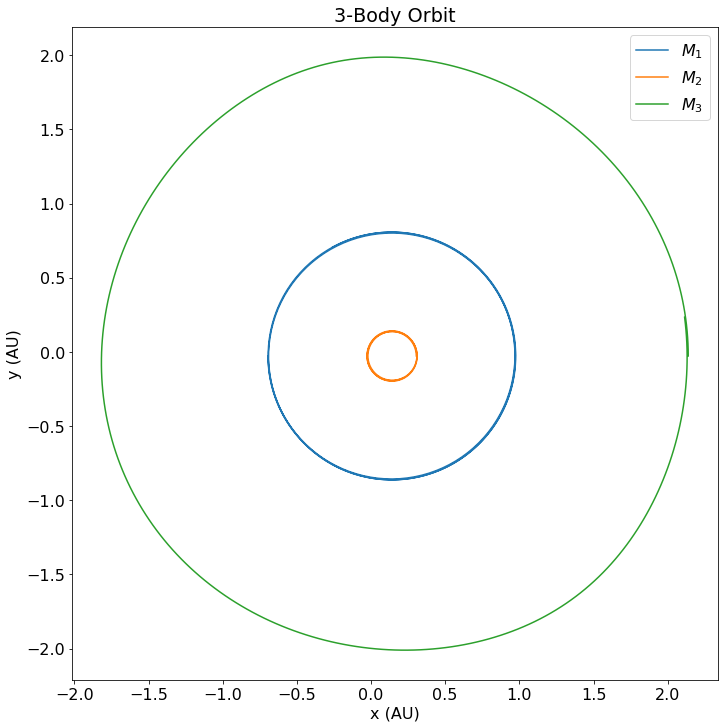

In [6]:
from astropy import units as u
Mjup = (u.Mjup/u.Msun)
#initial conditions, starting with 2 sun types and planet

#Initialization parameters: M1, M2, M3, a1, a2 (in solar masses and AU)
system1 = three_body(1,5,10*Mjup,1,2)

#ODE solver parameters: orbital periods (number of periods to let the system evolve)
system1.solve_3body(1)

#Plot results
system1.plots()

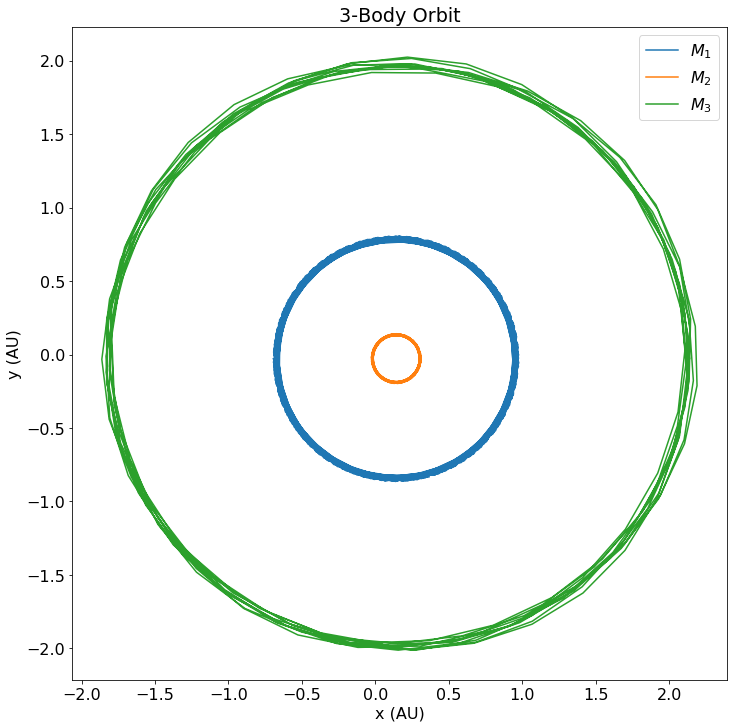

In [40]:
system1.solve_3body(10)
system1.plots()

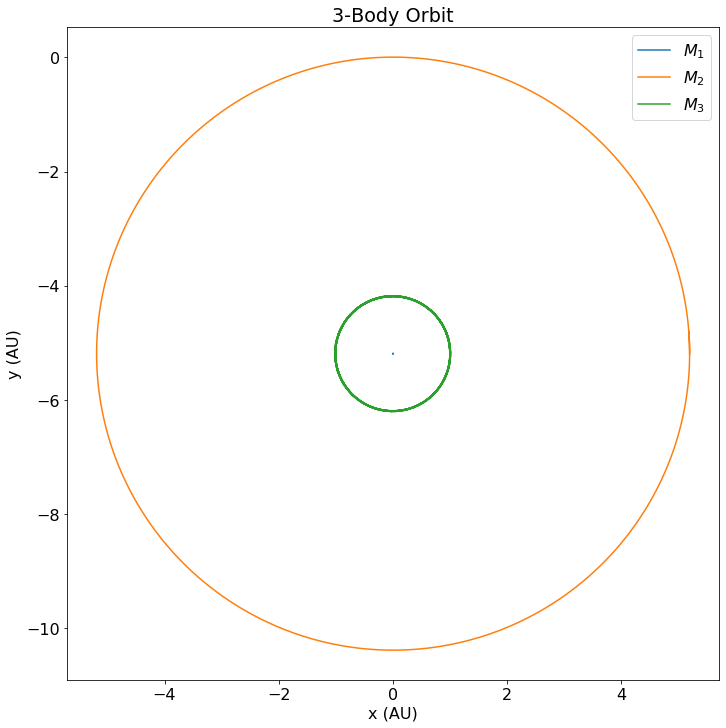

In [8]:
#initial conditions, sun jupiter earth

Mearth = (u.Mearth/u.Msun)
system1 = three_body(1,1*Mjup,1*Mearth,5.2,1)
system1.solve_3body(12)
system1.plots()

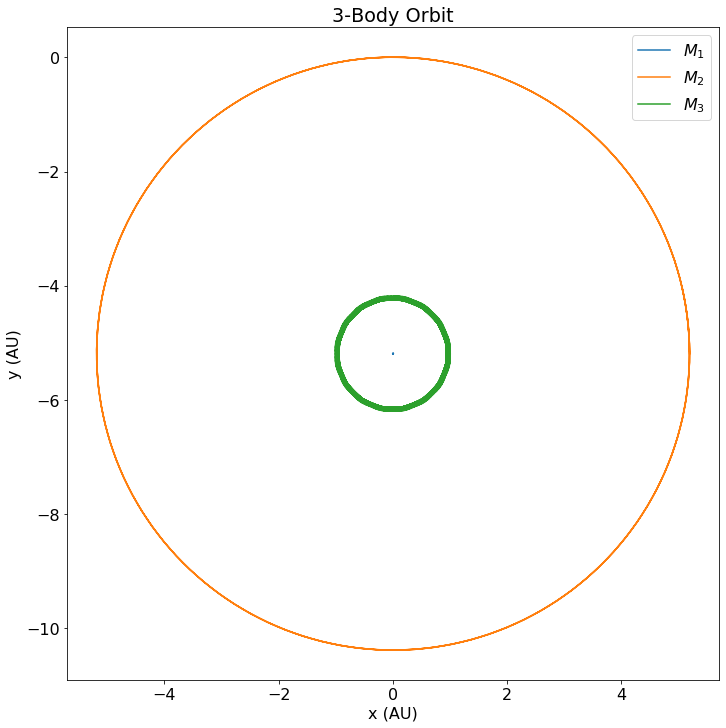

In [112]:
#3 orbits
system1.solve_3body(36)
system1.plots()

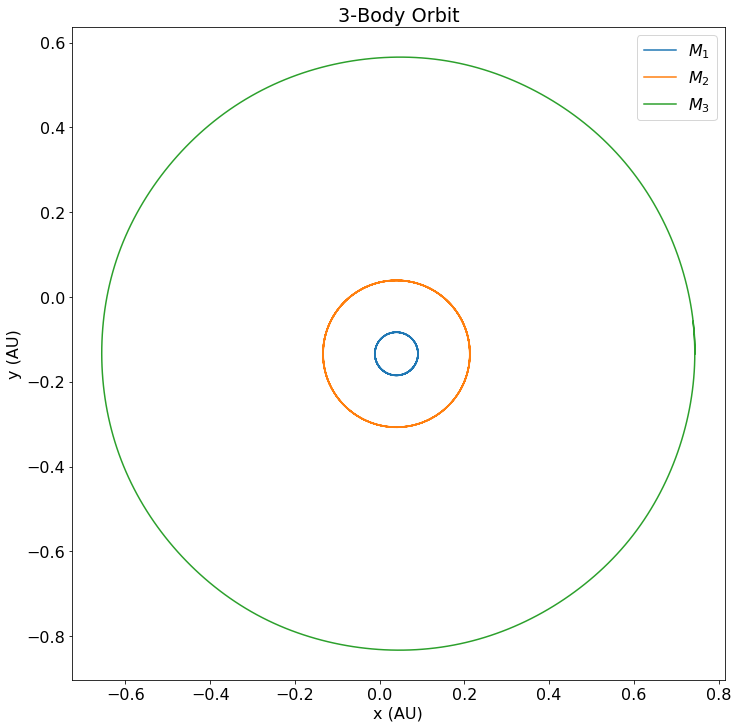

In [24]:
#using the known conditions of the Kepler-16 system to check

Mearth = (u.Mearth/u.Msun)
system2 = three_body(0.6897,0.20255,0.333*Mjup,.22431,.7048)
system2.solve_3body(1)
system2.plots()

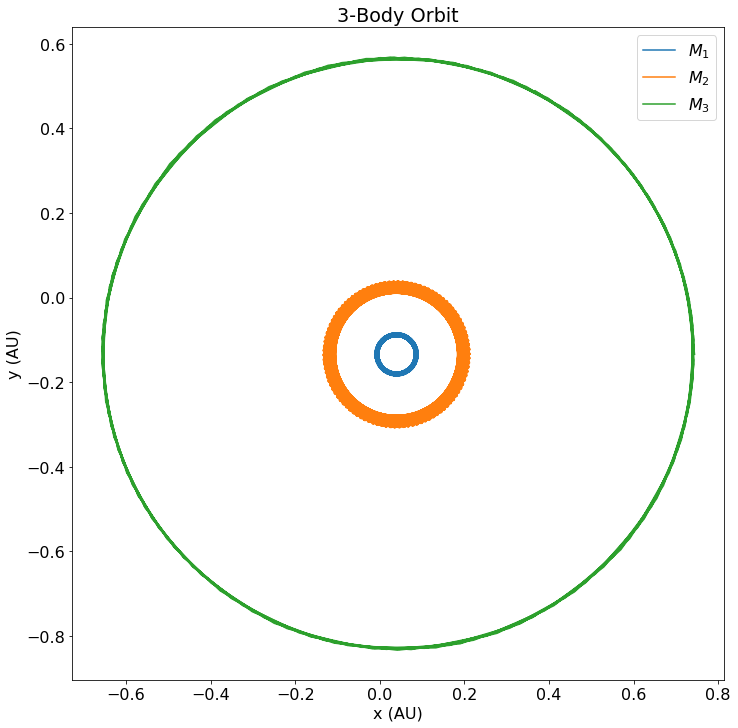

In [116]:
#after 10 planetary revolutions
x1,y1,x2,y2,x3,y3,tarr = system2.solve_3body(10)
system2.plots()

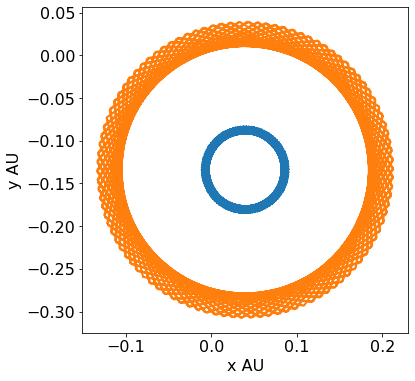

In [117]:
#close up of the binary stars after 10 planetary revolutions

plt.figure(figsize=(6,6))
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.xlabel('x AU')
plt.ylabel('y AU')
#plt.title('Circular Orbit')
plt.gca().set_aspect('equal')
plt.show()

In [5]:
from celluloid import Camera

#create movie for a systems evolution

def create_movie(system, pval,name):

    #solve system
    x1,y1,x2,y2,x3,y3,tarr = system.solve_3body(pval)

    # set up the plot
    fig = plt.figure(figsize=(6,6))
    camera = Camera(fig)

    # specify axis limits and labels
    plt.xlabel('x (AU)')
    plt.ylabel('y (AU)')
    plt.gca().set_aspect('equal')

    # loop over times, and take a "snapshot" at each time
    for tindx in range(len(tarr)):
        plt.plot(x1[tindx],y1[tindx],'o',color='r')
        plt.plot(x2[tindx],y2[tindx],'o',color='g')
        plt.plot(x3[tindx],y3[tindx],'o',color='b')
        # add the orbits
        plt.plot(x1[:tindx+1],y1[:tindx+1],color='r')
        plt.plot(x2[:tindx+1],y2[:tindx+1],color='g')
        plt.plot(x3[:tindx+1],y3[:tindx+1],color='b')
        #plt.plot(0,0,'*',color='black')
        camera.snap()

    # save the results
    camera.animate().save(name,fps=10,dpi=300)

In [4]:
#Kepler-16 system 

kep16 = three_body(0.6897,0.20255,0.333*Mjup,.22431,.7048)
kep16.solve_3body(1)
kep16.plots()
create_movie(kep16,1,"kepler16.gif")

NameError: name 'Mjup' is not defined

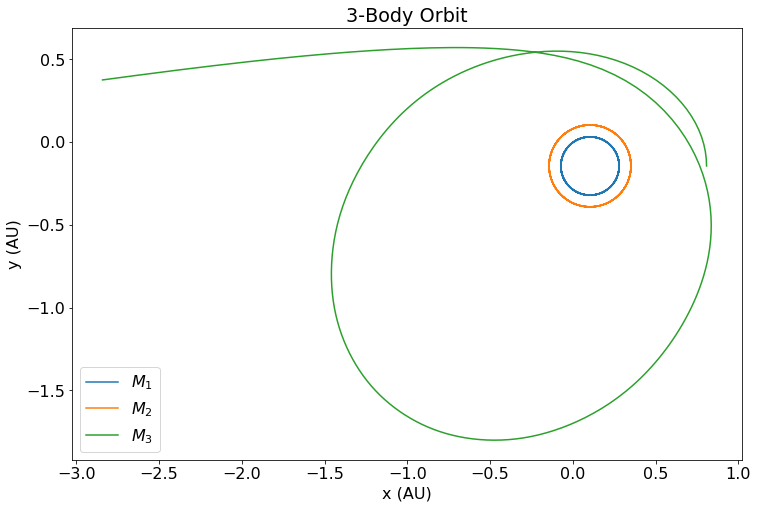

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


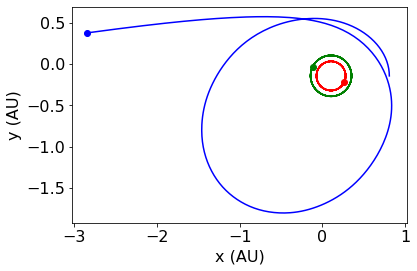

In [43]:
#modified Kepler-16 orbit
kepmod = three_body(1.6897,1.20255,1.333*Mjup,.42431,.7048)
kepmod.solve_3body(3)
kepmod.plots()
create_movie(kepmod,3,"modkepler16.gif")

## Subanalysis

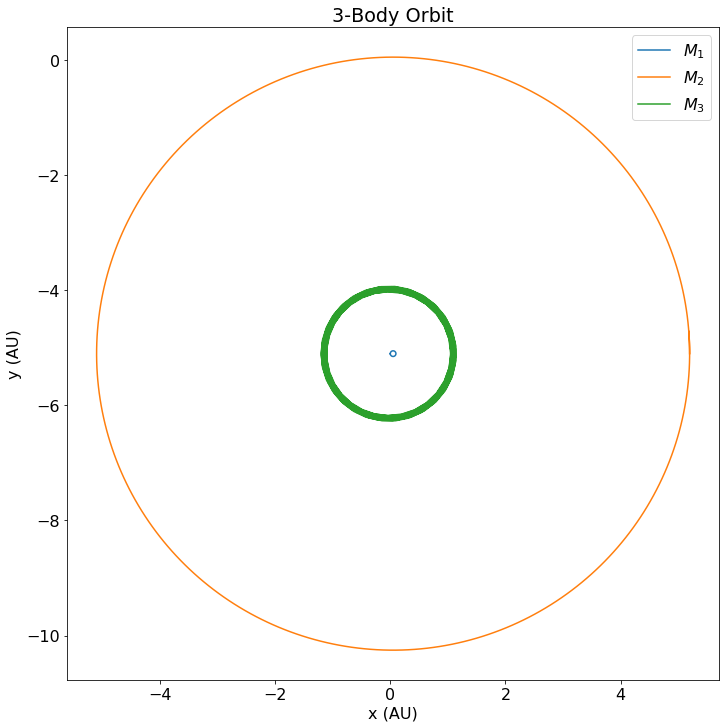

In [51]:
#What would happen if Jupiter was 10 times its current mass?
#initial conditions, sun jupiter earth

Mearth = (u.Mearth/u.Msun)
system1 = three_body(1,10*Mjup,1*Mearth,5.2,1)

#1 earth rotation
system1.solve_3body(12) 
system1.plots()

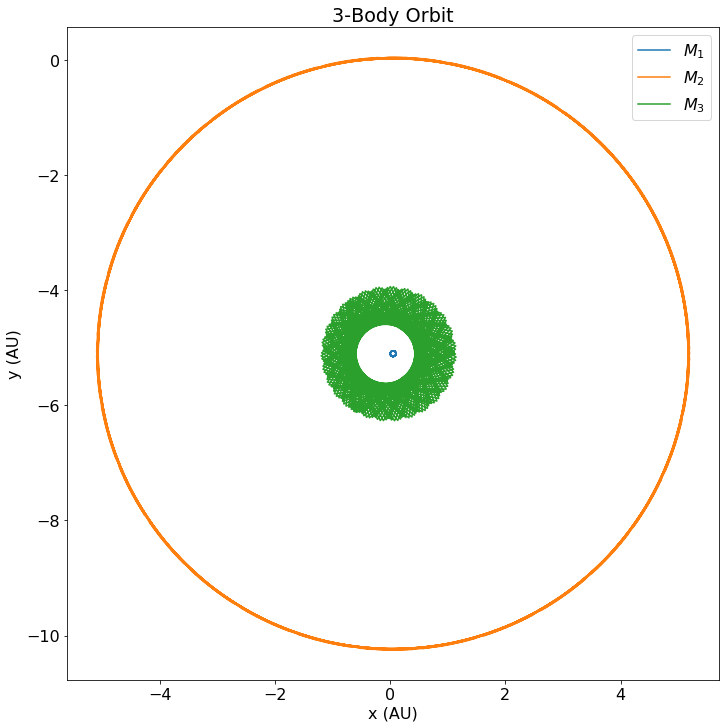

In [52]:
#after 10 earth rotations (10 years)
system1.solve_3body(120) 
system1.plots()



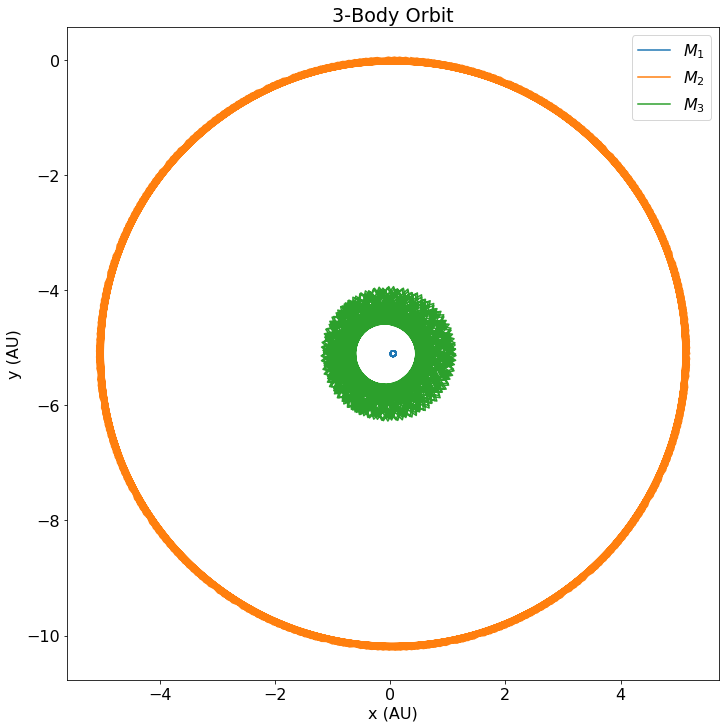

In [54]:
#after 20 earth rotations (20 years)
x1,y1,x2,y2,x3,y3,tarr = system1.solve_3body(240) 
system1.plots()

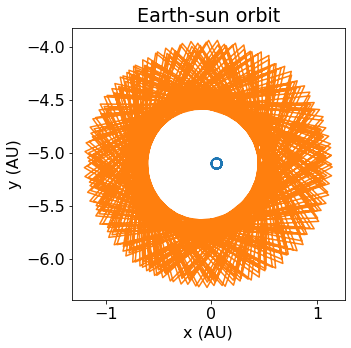

In [56]:
#zoom into earth sun orbits

plt.figure(figsize=(5,5))
plt.plot(x1,y1)
plt.plot(x3,y3)
plt.gca().set_aspect('equal')
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
plt.title('Earth-sun orbit')
plt.show()

#can clearly see that the sun is not always in the center of the orbits

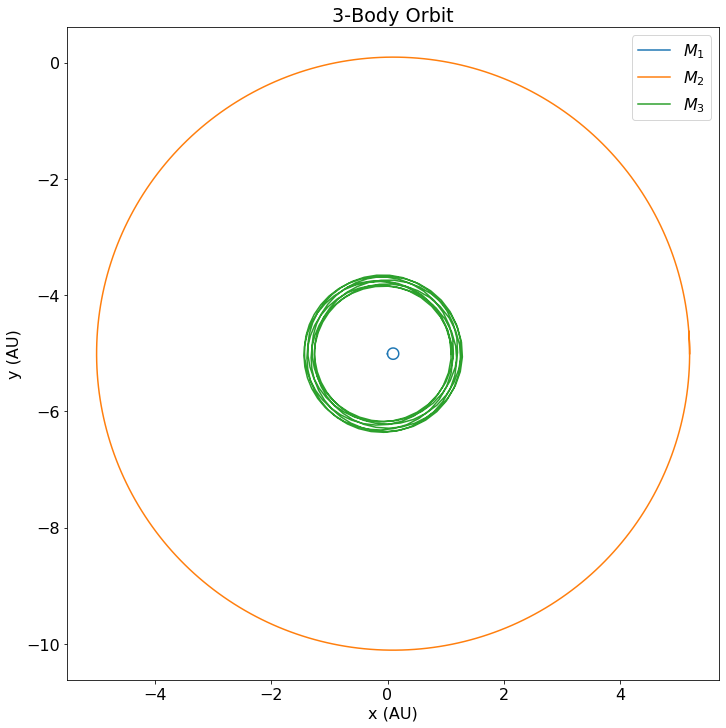

In [60]:
#What would happen if Jupiter was 20 times its current mass?
#initial conditions, sun jupiter earth
system1 = three_body(1,20*Mjup,1*Mearth,5.2,1)

#1 earth rotation
system1.solve_3body(12) 
system1.plots()

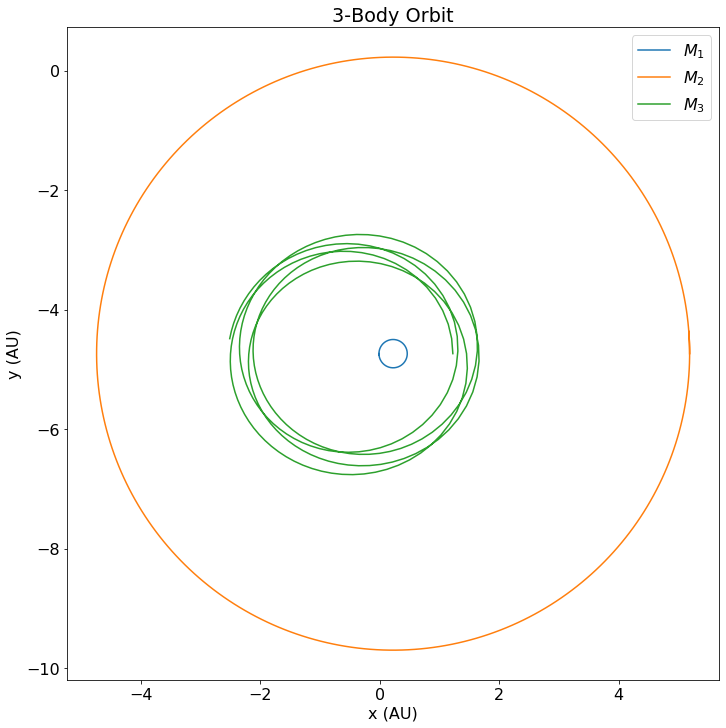

In [61]:
#What would happen if Jupiter was 50 times its current mass?
#initial conditions, sun jupiter earth
system1 = three_body(1,50*Mjup,1*Mearth,5.2,1)

#1 earth rotation
system1.solve_3body(12) 
system1.plots()

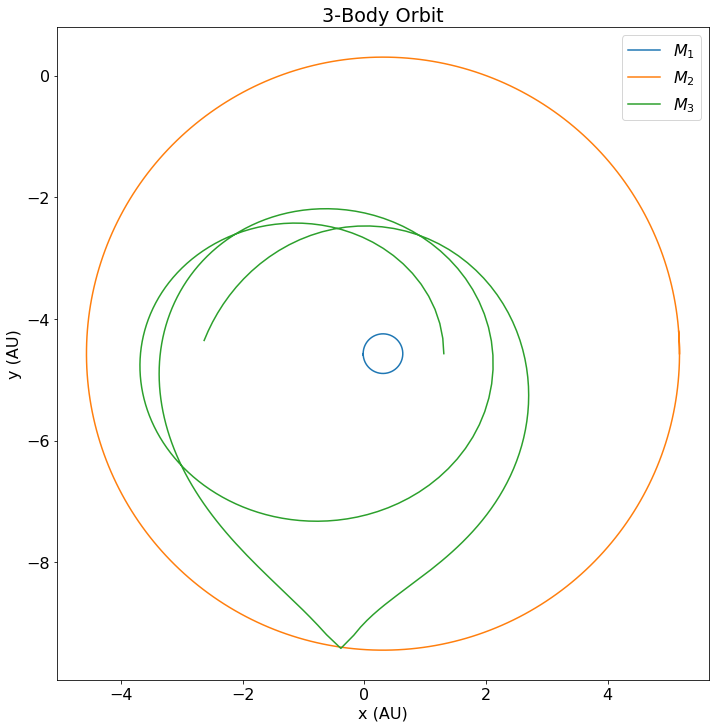

In [65]:
#What would happen if Jupiter was 70 times its current mass?
#initial conditions, sun jupiter earth
system1 = three_body(1,70*Mjup,1*Mearth,5.2,1)

#1 earth rotation
system1.solve_3body(12) 
system1.plots()

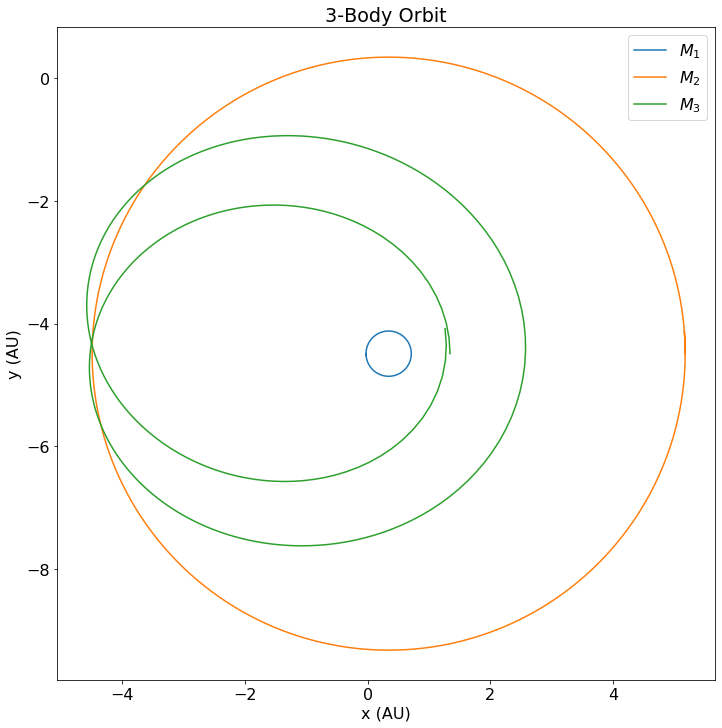

In [66]:
#What would happen if Jupiter was 80 times its current mass?
#initial conditions, sun jupiter earth
system1 = three_body(1,80*Mjup,1*Mearth,5.2,1)

#1 earth rotation
system1.solve_3body(12) 
system1.plots()

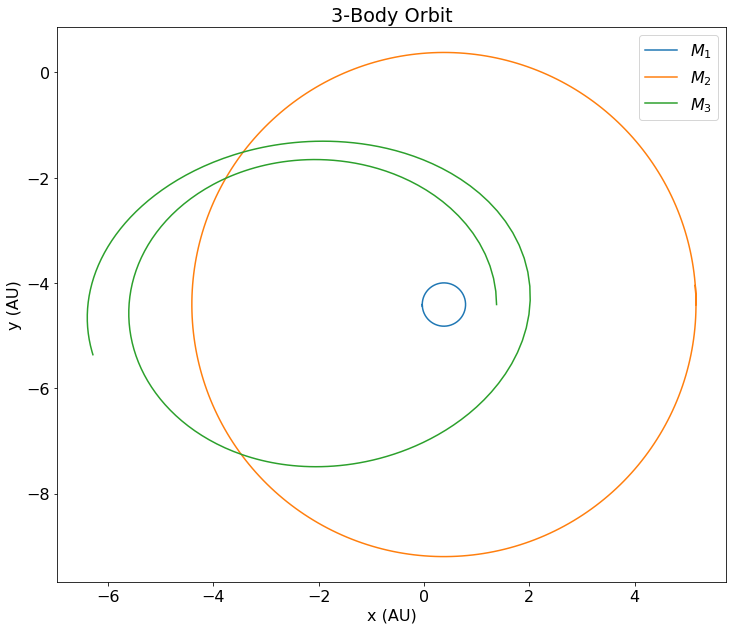

In [67]:
#What would happen if Jupiter was 90 times its current mass?
#initial conditions, sun jupiter earth
system1 = three_body(1,90*Mjup,1*Mearth,5.2,1)

#1 earth rotation
system1.solve_3body(12) 
system1.plots()

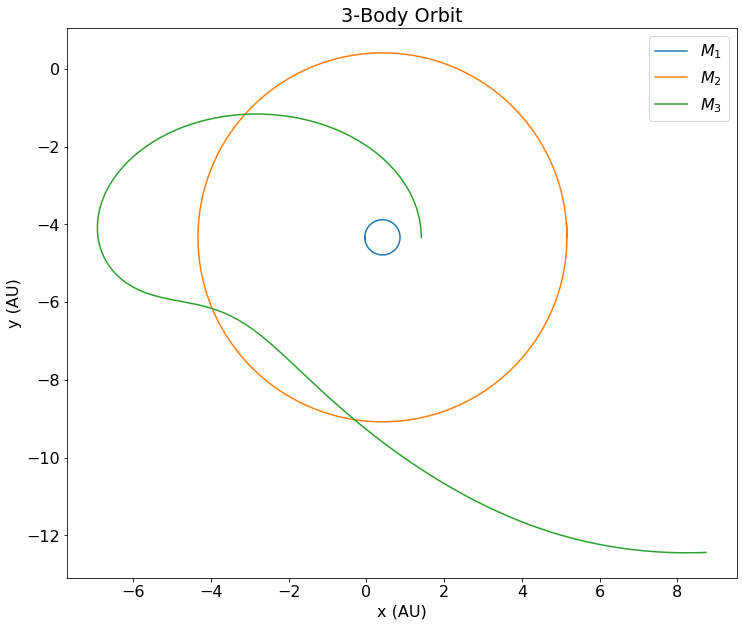

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


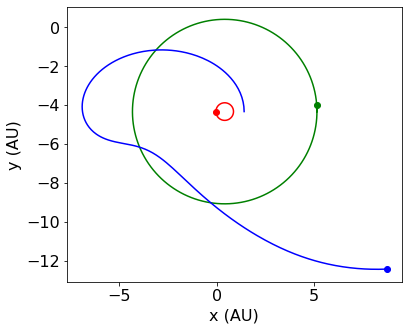

In [11]:
#What would happen if Jupiter was 100 times its current mass?
#initial conditions, sun jupiter earth
system1 = three_body(1,100*Mjup,1*Mearth,5.2,1)

#1 earth rotation
system1.solve_3body(12) 
system1.plots()

create_movie(system1,12,"t1.gif")

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


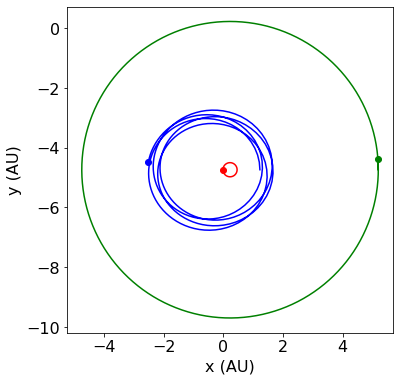

In [12]:
#What would happen if Jupiter was 50 times its current mass?
#initial conditions, sun jupiter earth
system2 = three_body(1,50*Mjup,1*Mearth,5.2,1)
system1.solve_3body(12) 

#1 earth rotation
create_movie(system2,12,"t2.gif")


MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


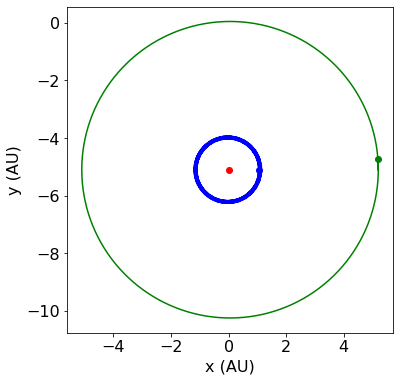

In [14]:
#What would happen if Jupiter was 10 times its current mass?
#initial conditions, sun jupiter earth

Mearth = (u.Mearth/u.Msun)
system1 = three_body(1,10*Mjup,1*Mearth,5.2,1)

#1 earth rotation
system1.solve_3body(12) 
create_movie(system1,12,"t3.gif")


## Conclusions

As we can see, as the mass of Jupiter increases the orbit of the Earth slowly shifts towards Jupiter until the orbit starts to intersect the orbit of Jupiter. When the mass of Jupiter is around 100 times its current mass, Earth is thrown out of orbit in a year or less (considering only these 3 bodies). 